In [134]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import eigvals, inv, det
from sklearn.gaussian_process.kernels import ConstantKernel, RBF, DotProduct, Matern
from GP import GaussianProcessRegressor

In [174]:
datasets = 2
n = 10
N = datasets*n                  # Total number of data points
percent_error = 0.1
x_sets = []                     # x for each dataset
y_sets = []                     # y for each dataset

x = np.zeros(N)                 # All x
y = np.zeros(N)                 # All y

total_errors = np.zeros(N)
systematic_errors = np.zeros(N)
dataset_sizes = np.zeros(datasets)
for i in range(datasets):
    energies = np.array([j+1 for j in range(n)]) + (0.5-np.random.rand(n))
    values = (0.5-np.random.rand(n) + energies)                # Provides overall linear relationship with correlated noise
    x_sets.append(energies)
    y_sets.append(values)
    
    s = percent_error*np.abs(values)
    
    for j in range(n):
        index = i*n+j
        x[index] = energies[j]
        y[index] = values[j]
        total_errors[index] = s[j] 
    dataset_sizes[i] = n

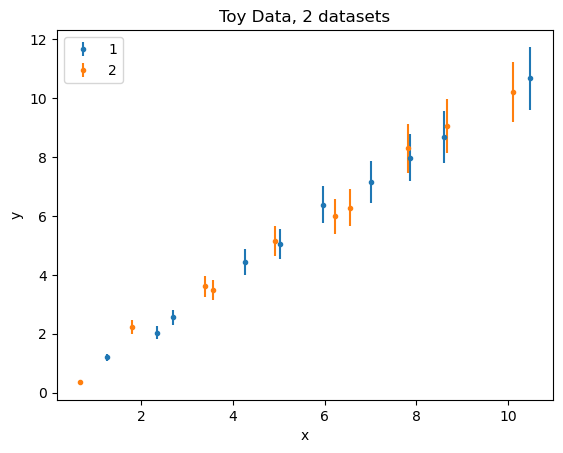

<Figure size 640x480 with 0 Axes>

In [175]:
# Plot the model data

for i in range(datasets):
    plt.errorbar(x_sets[i], y_sets[i], percent_error*np.abs(y_sets[i]), fmt='.', label=f'{i+1}')
plt.legend()
plt.xlabel(r'x')
plt.ylabel(r'y')
plt.title(f'Toy Data, {datasets} datasets')
plt.show()
plt.clf()

In [176]:
magnitude = 1                             # Initial values for kernel hyperparameters, which get set by extremizing the log-likelihood
length_scale = 1
kernel =  ConstantKernel(magnitude, constant_value_bounds=(10,1000)) * RBF(length_scale, length_scale_bounds=(0.1,2.1)) 
#kernel = ConstantKernel(magnitude) * RBF(length_scale) * DotProduct(1)
#kernel = ConstantKernel(magnitude, constant_value_bounds=(10,1000)) * Matern(length_scale, length_scale_bounds=(0.1,8), nu=2.5)
num_test = 300
x_test = np.linspace(0.5, n+0.5, num_test)

uncorrelated_gp = GaussianProcessRegressor(kernel=kernel)
uncorrelated_gp, uncorrelated_K11 = uncorrelated_gp.fit(x.reshape(-1,1), y, total=total_errors)
uncorrelated_mean, uncorrelated_std = uncorrelated_gp.predict(x_test.reshape(-1,1), return_std=True)
uncorrelated_theta = uncorrelated_gp.get_hyperparameter_values()

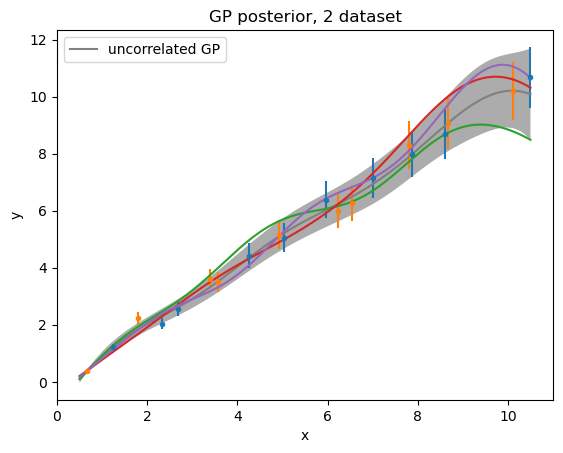

In [177]:
# Plot posterior

for i in range(datasets):
    plt.errorbar(x_sets[i], y_sets[i], percent_error*np.abs(y_sets[i]), fmt='.')

plt.plot(x_test, uncorrelated_mean, color='grey', label='uncorrelated GP')
plt.fill_between(x_test, uncorrelated_mean - 2*uncorrelated_std, uncorrelated_mean + 2*uncorrelated_std, color='grey', alpha=0.65, edgecolor='none')

samples = uncorrelated_gp.sample_y(x_test.reshape(-1,1), 3)
plt.plot(x_test, samples)

plt.legend()
plt.xlabel(r'x')
plt.ylabel(r'y')
plt.title(f'GP posterior, {datasets} dataset')
plt.show()

In [178]:
#percent_correlations = np.linspace(0,1,6)          # Percent of total error that is correlated with other data points
percent_correlations = [0.0,0.5,0.8,1]

for percent in percent_correlations:
    systematic_errors = percent * total_errors
    correlated_gp = GaussianProcessRegressor(kernel=kernel)
    correlated_gp, correlated_K11 = correlated_gp.fit(x.reshape(-1,1), y, total=total_errors, norms=systematic_errors, points=dataset_sizes)
    print(round(percent,1))
    print(correlated_gp.get_hyperparameter_values())
    #print(eigvals(correlated_K11))
    print(-correlated_gp.log_marginal_likelihood_value_)
    #print(inv(correlated_K11))
    print()


0.0
[20.47584992  2.1       ]
26.78310475630446

0.5
[20.03118572  2.1       ]
26.381778281331847

0.8
[18.5372464  2.1      ]
26.14776131690185

1
[10.   2.1]
44.40622210407102



/Users/timlaunders/miniconda3/envs/linx/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 10. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


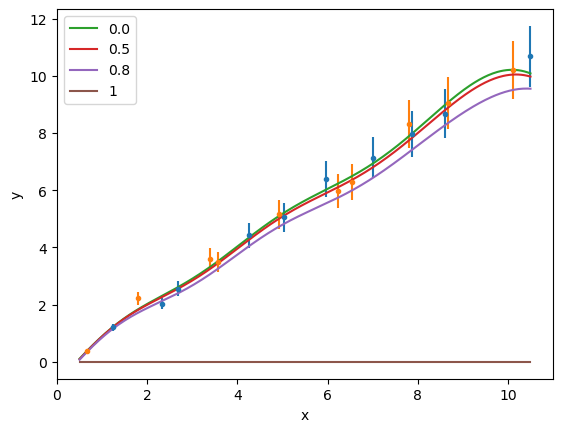

In [179]:
for i in range(datasets):
    plt.errorbar(x_sets[i], y_sets[i], percent_error*np.abs(y_sets[i]), fmt='.')

for percent in percent_correlations:
    systematic_errors = percent * total_errors
    correlated_gp = GaussianProcessRegressor(kernel=kernel)
    correlated_gp, correlated_K11 = correlated_gp.fit(x.reshape(-1,1), y, total=total_errors, norms=systematic_errors, points=dataset_sizes)
    correlated_mean, correlated_std = correlated_gp.predict(x_test.reshape(-1,1), return_std=True)
    plt.plot(x_test, correlated_mean, label=str(round(percent,2)))
    #plt.fill_between(x_test, correlated_mean - uncorrelated_std, correlated_mean + uncorrelated_std, alpha=0.65, edgecolor='none')

plt.legend()
plt.xlabel(r'x')
plt.ylabel(r'y')
plt.show()


What happens if the kernel hyperparameters are fixed to some other values?

In [180]:
uncorrelated_theta = [100,2]

#fixed_kernel = ConstantKernel(uncorrelated_theta[0], constant_value_bounds='fixed') * RBF(uncorrelated_theta[1], length_scale_bounds='fixed') 
fixed_kernel = ConstantKernel(uncorrelated_theta[0], constant_value_bounds='fixed') * Matern(uncorrelated_theta[1], length_scale_bounds='fixed', nu=2.5) 

for percent in percent_correlations:
    systematic_errors = percent * total_errors
    correlated_gp = GaussianProcessRegressor(kernel=fixed_kernel)
    correlated_gp, correlated_K11 = correlated_gp.fit(x.reshape(-1,1), y, total=total_errors, norms=systematic_errors, points=dataset_sizes)
    print(round(percent,1))
    #print(eigvals(correlated_K11))
    print(-correlated_gp.log_marginal_likelihood_value_)
    #print(correlated_K11)
    print()


0.0
36.80412982976274

0.5
36.50350732343735

0.8
35.4242388810103

1
32.70129201741003



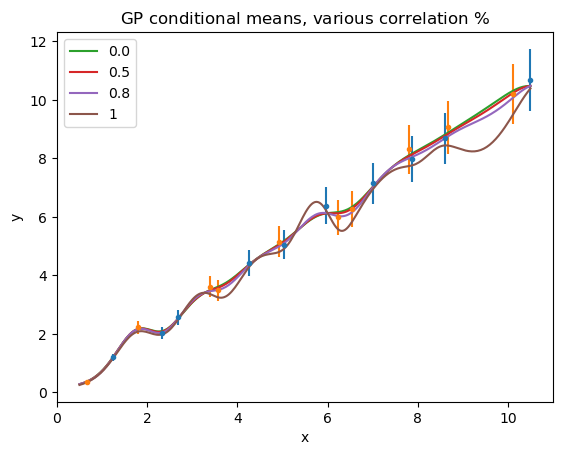

In [181]:
for i in range(datasets):
    plt.errorbar(x_sets[i], y_sets[i], percent_error*np.abs(y_sets[i]), fmt='.')

for percent in percent_correlations:
    systematic_errors = percent * total_errors
    correlated_gp = GaussianProcessRegressor(kernel=fixed_kernel)
    correlated_gp, correlated_K11 = correlated_gp.fit(x.reshape(-1,1), y, total=total_errors, norms=systematic_errors, points=dataset_sizes)
    correlated_mean, correlated_std = correlated_gp.predict(x_test.reshape(-1,1), return_std=True)
    plt.plot(x_test, correlated_mean, label=str(round(percent,2)))
plt.legend()
plt.xlabel(r'x')
plt.ylabel(r'y')
plt.title(r'GP conditional means, various correlation $\%$')
plt.show()

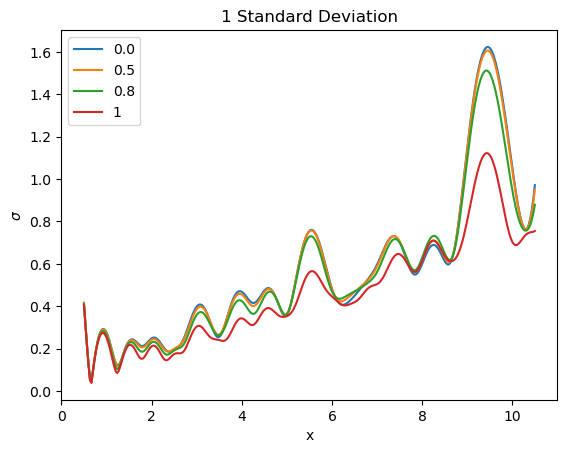

In [182]:
for percent in percent_correlations:
    systematic_errors = percent * total_errors
    correlated_gp = GaussianProcessRegressor(kernel=fixed_kernel)
    correlated_gp, correlated_K11 = correlated_gp.fit(x.reshape(-1,1), y, total=total_errors, norms=systematic_errors, points=dataset_sizes)
    correlated_mean, correlated_std = correlated_gp.predict(x_test.reshape(-1,1), return_std=True)
    plt.plot(x_test, correlated_std, label=str(round(percent,2)))
plt.legend()
plt.xlabel(r'x')
plt.ylabel(r'$\sigma$')
plt.title('1 Standard Deviation')
plt.show()

Make plot of log-likelihood landscape for both hyperparameters.

In [183]:
def get_negative_log_likelihood(constant_scale, length_scale, correlation):
    #test_kernel = ConstantKernel(constant_scale, constant_value_bounds='fixed') * Matern(length_scale, length_scale_bounds='fixed', nu=2.5) 
    test_kernel = ConstantKernel(constant_scale, constant_value_bounds='fixed') * RBF(length_scale, length_scale_bounds='fixed') 
    gp = GaussianProcessRegressor(kernel=test_kernel)
    try:
        gp, _ = gp.fit(x.reshape(-1,1), y, total=total_errors, norms=correlation*total_errors, points=dataset_sizes)
        return -gp.log_marginal_likelihood_value_
    except:
        return 100


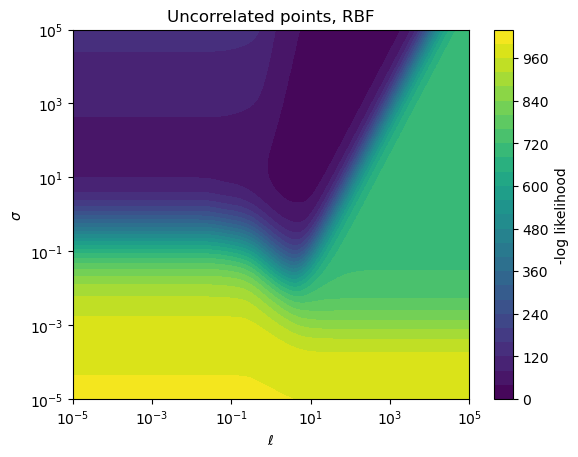

In [184]:
sigma = np.logspace(-5,5,100)
l = np.logspace(-5,5,100)

L, Sigma = np.meshgrid(l, sigma)
likelihoods = np.vectorize(get_negative_log_likelihood)(Sigma, L, correlation=0)

plt.contourf(L, Sigma, likelihoods, 30, cmap='viridis')
plt.colorbar(label='-log likelihood')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$\ell$')
plt.ylabel(r'$\sigma$')
#plt.title('Uncorrelated points, Matern-7/2')
plt.title('Uncorrelated points, RBF')
plt.show()

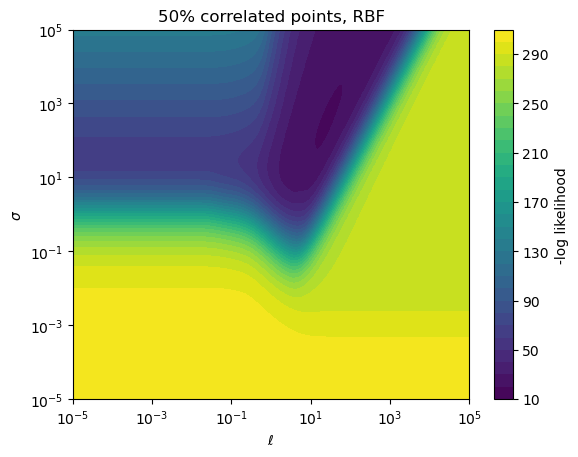

In [185]:
L, Sigma = np.meshgrid(l, sigma)
likelihoods = np.vectorize(get_negative_log_likelihood)(Sigma, L, correlation=0.5)

plt.contourf(L, Sigma, likelihoods, 30, cmap='viridis')
plt.colorbar(label='-log likelihood')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$\ell$')
plt.ylabel(r'$\sigma$')
#plt.title('50% correlated points, Matern-7/2')
plt.title('50% correlated points, RBF')
plt.show()

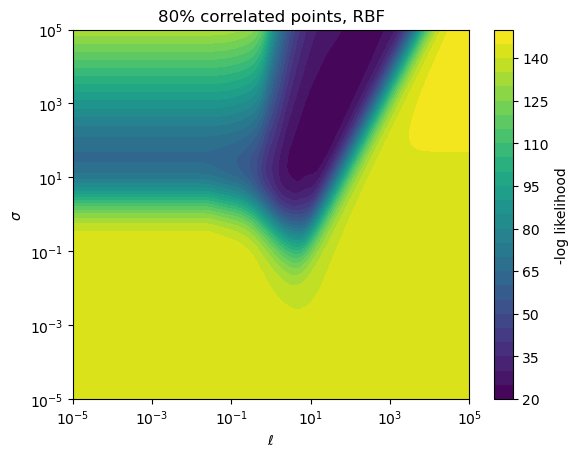

In [186]:
L, Sigma = np.meshgrid(l, sigma)
likelihoods = np.vectorize(get_negative_log_likelihood)(Sigma, L, correlation=0.8)

plt.contourf(L, Sigma, likelihoods, 30, cmap='viridis')
plt.colorbar(label='-log likelihood')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$\ell$')
plt.ylabel(r'$\sigma$')
#plt.title('80% correlated points, Matern-7/2')
plt.title('80% correlated points, RBF')
plt.show()

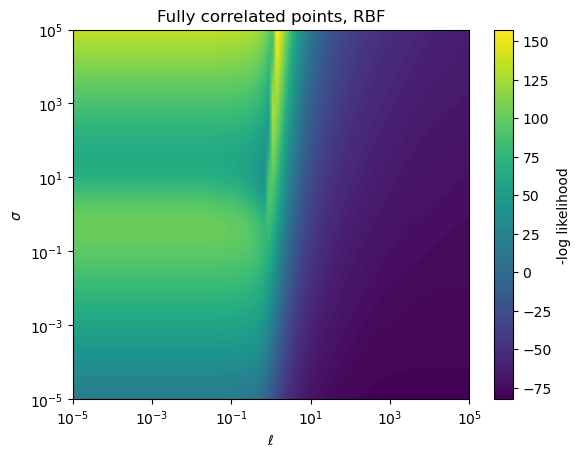

In [187]:
L, Sigma = np.meshgrid(l, sigma)
likelihoods = np.vectorize(get_negative_log_likelihood)(Sigma, L, correlation=1)

plt.contourf(L, Sigma, likelihoods, 100, cmap='viridis')
plt.colorbar(label='-log likelihood')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$\ell$')
plt.ylabel(r'$\sigma$')
#plt.title('Fully correlated points, Matern-7/2')
plt.title('Fully correlated points, RBF')
#plt.xlim(.1,8)
#plt.ylim(10,1000)
plt.show()

Now, do the same but with the data normalized to have zero mean and unit variance for fitting. 

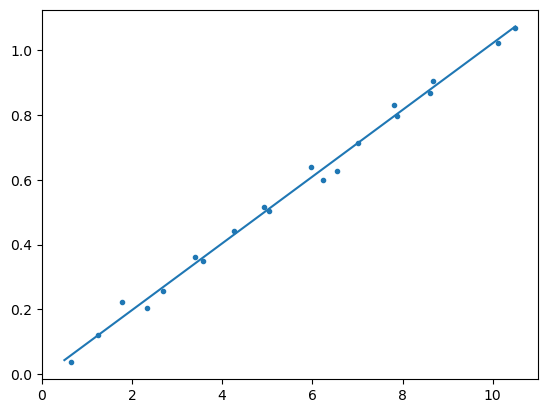

In [188]:
plt.scatter(x, total_errors, marker='.')
std_coef = np.polyfit(x, total_errors,1)
def std(X):
    return std_coef[0] * X + std_coef[1]
    #return np.ones(len(X)) * np.mean(total_errors)
plt.plot(x_test, std(x_test))

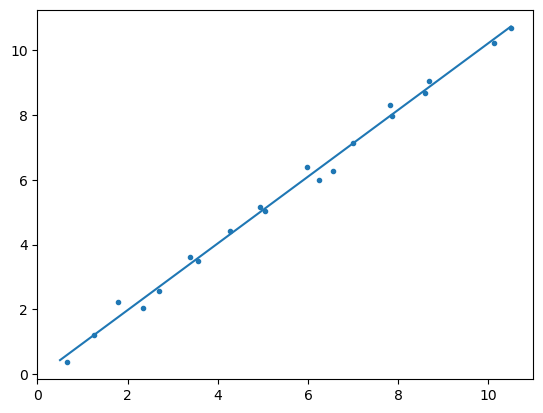

In [189]:
plt.scatter(x, y, marker='.')
mean_coef = np.polyfit(x, y, 1)
def mean(X):
    return mean_coef[0] * X + mean_coef[1]
    #return np.ones(len(X)) * np.mean(x)
plt.plot(x_test, mean(x_test))

<ErrorbarContainer object of 3 artists>

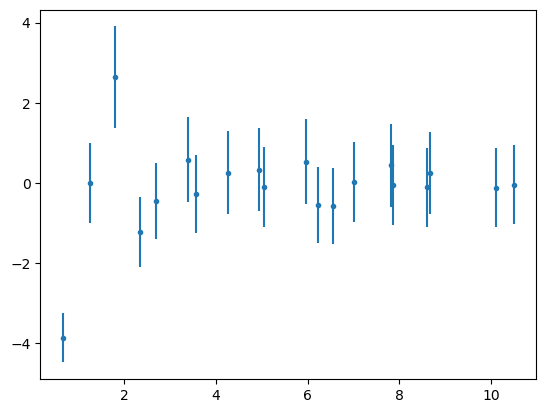

In [190]:
fit_y = (y - mean(x))/std(x)
plt.errorbar(x, fit_y, total_errors/std(x), fmt='.')

[1.93521615 0.35602943]
[[2.93487467e+000 8.95769107e-001 9.54991425e-001 1.02551715e+000
  9.89400545e-001 1.05280472e+000 1.00162739e+000 9.94714205e-001
  9.89100895e-001 9.95661496e-001 4.87217500e-001 6.04354230e-001
  2.49002757e-008 1.13037194e-009 1.09326665e-023 4.65649049e-043
  1.34793498e-048 2.65740251e-074 5.44675302e-095 2.90509978e-135]
 [8.95769107e-001 2.70614225e+000 2.02727838e+000 9.00583190e-001
  8.68865762e-001 9.24545652e-001 8.79603058e-001 8.73532081e-001
  8.68602618e-001 8.74363967e-001 2.79334144e-005 5.95881618e-001
  2.36877184e-002 4.85978629e-003 5.72459142e-012 1.79948962e-026
  7.75784053e-031 8.02761916e-052 2.73979618e-069 3.53986065e-104]
 [9.54991425e-001 2.02727838e+000 2.84651192e+000 9.79244982e-001
  9.44661002e-001 1.00519811e+000 9.56334961e-001 9.49734384e-001
  9.44374902e-001 9.50638840e-001 1.62522395e-007 8.04945097e-002
  2.72234845e-001 9.08408448e-002 4.67063952e-009 5.45249516e-022
  5.61616311e-026 1.93361142e-045 7.21649934e-062 

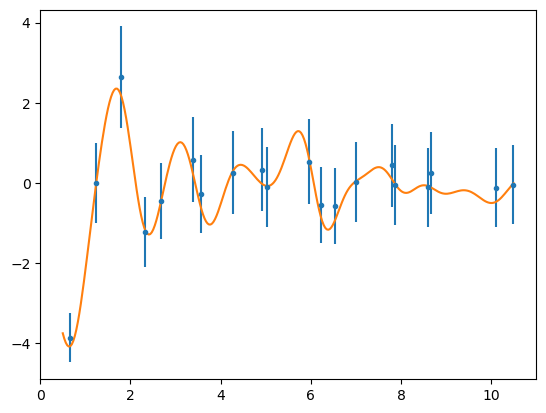

In [ ]:
#kernel = ConstantKernel(magnitude) * RBF(length_scale)
#kernel = ConstantKernel(magnitude) * Matern(length_scale, nu=2.5)
kernel = ConstantKernel(magnitude) * RBF(length_scale, length_scale_bounds=(0.1,1.1))


fit_gp = GaussianProcessRegressor(kernel)
fit_gp, fit_K11 = fit_gp.fit(x.reshape(-1,1), fit_y, total=total_errors/std(x), norms=1*total_errors/std(x), points=dataset_sizes)
fit_mean, fit_std = fit_gp.predict(x_test.reshape(-1,1), return_std=True)
print(fit_gp.get_hyperparameter_values())

plt.errorbar(x, fit_y, total_errors/std(x), fmt='.')
plt.plot(x_test, fit_mean)

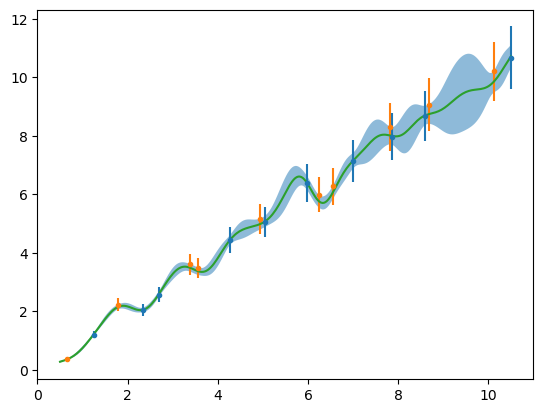

In [197]:
for i in range(datasets):
    plt.errorbar(x_sets[i], y_sets[i], percent_error*np.abs(y_sets[i]), fmt='.', label=f'{i+1}')

mu = fit_mean*std(x_test) + mean(x_test)
sig = fit_std*std(x_test)
plt.plot(x_test, fit_mean*std(x_test) + mean(x_test))
plt.fill_between(x_test, mu-1*sig, mu+1*sig, alpha=0.5)

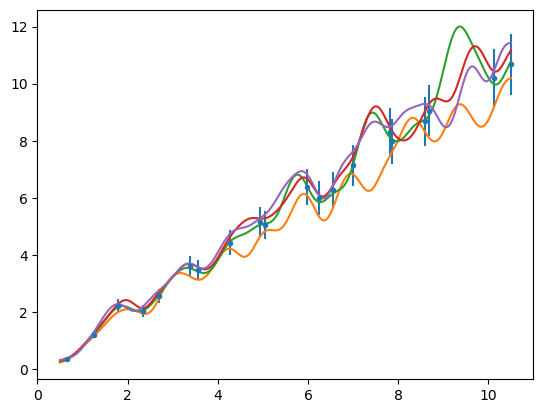

In [198]:
num_samples = 4
samples = fit_gp.sample_y(x_test.reshape(-1,1), num_samples)
plt.errorbar(x,y,total_errors, fmt='.')
for i in range(num_samples):
    plt.plot(x_test, std(x_test)*samples[:,i] + mean(x_test))